In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

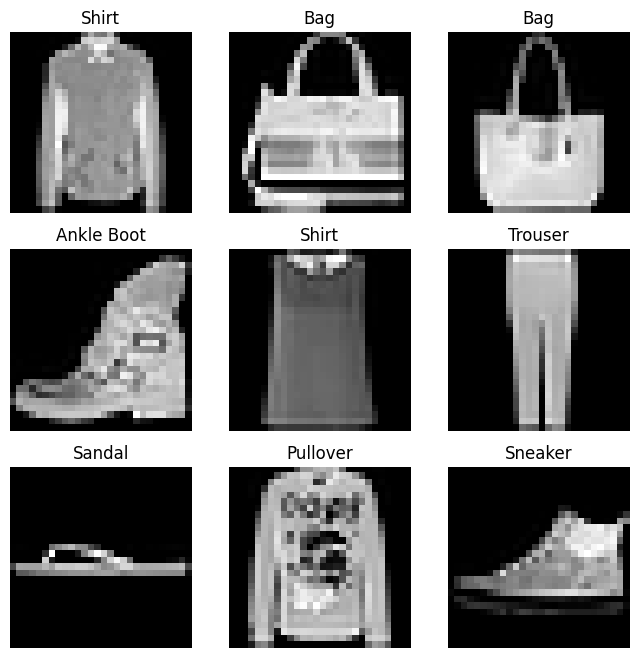

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
idx = (training_data.targets == 0) | (training_data.targets == 1) | (training_data.targets == 2) | (training_data.targets == 3) | (training_data.targets == 4)
trainset_1 = torch.utils.data.Subset(training_data, [i for i, x in enumerate(idx) if x])
trainset_2 = torch.utils.data.Subset(training_data, [i for i, x in enumerate(idx) if not x])

In [10]:
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=64,
                                            shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=64,
                                            shuffle=True, num_workers=2)

In [11]:
idx = (test_data.targets == 0) | (test_data.targets == 1) | (test_data.targets == 2) | (test_data.targets == 3) | (test_data.targets == 4)
testset_1 = torch.utils.data.Subset(test_data, [i for i, x in enumerate(idx) if x])
testset_2 = torch.utils.data.Subset(test_data, [i for i, x in enumerate(idx) if not x])

In [12]:
testloader_1 = torch.utils.data.DataLoader(testset_1, batch_size=100,
                                            shuffle=False, num_workers=2)
testloader_2 = torch.utils.data.DataLoader(testset_2, batch_size=100,
                                            shuffle=False, num_workers=2)

In [13]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader_1, model, loss_fn, optimizer)
    test(testloader_1, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309290  [    0/30000]
Test Error: 
 Accuracy: 32.3%, Avg loss: 2.190969 

Epoch 2
-------------------------------
loss: 2.194293  [    0/30000]
Test Error: 
 Accuracy: 26.2%, Avg loss: 2.016397 

Epoch 3
-------------------------------
loss: 2.029409  [    0/30000]
Test Error: 
 Accuracy: 23.1%, Avg loss: 1.726033 

Epoch 4
-------------------------------
loss: 1.738090  [    0/30000]
Test Error: 
 Accuracy: 55.0%, Avg loss: 1.524473 

Epoch 5
-------------------------------
loss: 1.520590  [    0/30000]
Test Error: 
 Accuracy: 62.6%, Avg loss: 1.351270 

Epoch 6
-------------------------------
loss: 1.332332  [    0/30000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.176128 

Epoch 7
-------------------------------
loss: 1.135961  [    0/30000]
Test Error: 
 Accuracy: 63.6%, Avg loss: 1.050517 

Epoch 8
-------------------------------
loss: 1.063640  [    0/30000]
Test Error: 
 Accuracy: 63.4%, Avg loss: 0.969564 

Epoch 9
----------------

In [14]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [15]:
h1 = model.linear_relu_stack[1].register_forward_hook(get_features("fl1"))
h2 = model.linear_relu_stack[3].register_forward_hook(get_features("fl2"))
h3 = model.linear_relu_stack[5].register_forward_hook(get_features("fl3"))

In [16]:
FEATS = []
features={}
with torch.no_grad():
    for idx, (X, y) in enumerate(testloader_1):
        X, y = X.to(device), y.to(device)

        # forward pass [with feature extraction]
        preds = model(X)

In [17]:
features

{'fl1': tensor([[0.9098, 1.6562, 0.5162,  ..., 0.1912, 0.0000, 0.0000],
         [0.4099, 1.3837, 0.1522,  ..., 0.4672, 0.0125, 0.0000],
         [0.2932, 0.7885, 0.2407,  ..., 0.0756, 0.0000, 0.0000],
         ...,
         [0.6806, 1.7800, 0.1672,  ..., 0.3745, 0.0000, 0.0000],
         [0.4232, 1.0015, 0.0000,  ..., 0.3632, 0.0000, 0.0000],
         [0.7863, 1.5349, 0.2186,  ..., 0.3455, 0.0000, 0.0000]],
        device='cuda:0'),
 'fl2': tensor([[1.5716, 0.8975, 0.0000,  ..., 0.6193, 0.0000, 0.6718],
         [1.1921, 1.4051, 0.0000,  ..., 1.1226, 0.0000, 1.3893],
         [0.5547, 0.5621, 0.0000,  ..., 0.7028, 0.0000, 0.9560],
         ...,
         [1.3061, 0.4380, 0.0000,  ..., 0.2648, 0.0000, 0.1680],
         [0.6872, 0.2259, 0.0000,  ..., 0.1145, 0.0000, 0.0628],
         [1.3141, 0.6629, 0.0000,  ..., 0.3255, 0.0000, 0.3020]],
        device='cuda:0'),
 'fl3': tensor([[0.0000, 0.0000, 1.4662,  ..., 0.0000, 0.3406, 0.0000],
         [0.0000, 0.8110, 0.2738,  ..., 0.0000, 1.67

In [19]:
h1.remove()
h2.remove()
h3.remove()

In [23]:
len(features['fl1'])

100

In [41]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader_2, model, loss_fn, optimizer)
    test(testloader_1, model, loss_fn)
    test(testloader_2, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.672738  [    0/30000]
Test Error: 
 Accuracy: 14.0%, Avg loss: 5.907332 

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.346965 

Done!


In [42]:
h1 = model.linear_relu_stack[1].register_forward_hook(get_features("fl1_task2_3"))
h2 = model.linear_relu_stack[3].register_forward_hook(get_features("fl2_task2_3"))
h3 = model.linear_relu_stack[5].register_forward_hook(get_features("fl3_task2_3"))

In [43]:
with torch.no_grad():
    for idx, (X, y) in enumerate(testloader_1):
        X, y = X.to(device), y.to(device)

        # forward pass [with feature extraction]
        preds = model(X)

In [44]:
h1.remove()
h2.remove()
h3.remove()

In [36]:
features

{'fl1': tensor([[0.9098, 1.6562, 0.5162,  ..., 0.1912, 0.0000, 0.0000],
         [0.4099, 1.3837, 0.1522,  ..., 0.4672, 0.0125, 0.0000],
         [0.2932, 0.7885, 0.2407,  ..., 0.0756, 0.0000, 0.0000],
         ...,
         [0.6806, 1.7800, 0.1672,  ..., 0.3745, 0.0000, 0.0000],
         [0.4232, 1.0015, 0.0000,  ..., 0.3632, 0.0000, 0.0000],
         [0.7863, 1.5349, 0.2186,  ..., 0.3455, 0.0000, 0.0000]],
        device='cuda:0'),
 'fl2': tensor([[1.5716, 0.8975, 0.0000,  ..., 0.6193, 0.0000, 0.6718],
         [1.1921, 1.4051, 0.0000,  ..., 1.1226, 0.0000, 1.3893],
         [0.5547, 0.5621, 0.0000,  ..., 0.7028, 0.0000, 0.9560],
         ...,
         [1.3061, 0.4380, 0.0000,  ..., 0.2648, 0.0000, 0.1680],
         [0.6872, 0.2259, 0.0000,  ..., 0.1145, 0.0000, 0.0628],
         [1.3141, 0.6629, 0.0000,  ..., 0.3255, 0.0000, 0.3020]],
        device='cuda:0'),
 'fl3': tensor([[0.0000, 0.0000, 1.4662,  ..., 0.0000, 0.3406, 0.0000],
         [0.0000, 0.8110, 0.2738,  ..., 0.0000, 1.67

In [27]:
len(features['fl1'])

100

In [28]:
emb_loss = nn.CosineEmbeddingLoss()

In [37]:
emb_loss(features['fl1'].cpu(), features['fl1_task2'].cpu(), target=torch.ones(100))

tensor(0.0387)

In [30]:
emb_loss(features['fl2'].cpu(), features['fl2_task2'].cpu(), target=torch.ones(100))

tensor(0.1398)

In [31]:
emb_loss(features['fl3'].cpu(), features['fl3_task2'].cpu(), target=torch.ones(100))

tensor(0.3573)

In [38]:
emb_loss(features['fl1'].cpu(), features['fl1_task2_2'].cpu(), target=torch.ones(100))

tensor(0.0379)

In [39]:
emb_loss(features['fl2'].cpu(), features['fl2_task2_2'].cpu(), target=torch.ones(100))

tensor(0.1492)

In [40]:
emb_loss(features['fl3'].cpu(), features['fl3_task2_2'].cpu(), target=torch.ones(100))

tensor(0.4209)

In [45]:
emb_loss(features['fl1'].cpu(), features['fl1_task2_3'].cpu(), target=torch.ones(100))

tensor(0.0352)

In [46]:
emb_loss(features['fl2'].cpu(), features['fl2_task2_3'].cpu(), target=torch.ones(100))

tensor(0.1440)

In [47]:
emb_loss(features['fl3'].cpu(), features['fl3_task2_3'].cpu(), target=torch.ones(100))

tensor(0.4270)

In [28]:
features['fl1'].cpu().shape

torch.Size([4, 300])